# Credit Card Fraud Detection 

**European Banking Authority (EBA)** investigates fraudulent credit card transactions. Labeling the data takes a lot of investigation time and resources. The EBA needs help from linkit e.V.'s brightest minds to speed up the initial detection process.

<img src='images/EBAcredit.png'>

EBA sends a dataset of **two** consecutive days of transaction records by european credit cardholders.

They started labeling **442 frauds** out of **284,807 transactions**. Therefore, the dataset is **highly unbalanced**. Since EBA's investigations are not completed, **not all frauds have been detected in the dataset**.

# EBA estimates, that around 11% additional frauds must be detected

Help EBA to **detect all frauds by setting up a fraud detection model**.

Due to law restrictions EBA sends anonymous data. More specifically,

- **28 principal components** obtained with **PCA** (column **V1, V2, ..., V28**)
- **Time** is the number of **seconds** elapsed since the first transaction (note that two days have 172800 seconds and the first transaction starts at midnight, 12am)
- **Amount** describes the amount of the credit card transaction in EUR
- **Class** is the dependant variable that is **1** if EBA detected a fraudulent action and **0** otherwise. Investigations are **not** complete such that a little number of frauds still can be observed with label 0

In [230]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Analyzing the Dataset

In [231]:
# read the EBA dataset
dat = pd.read_csv('data/EBA_KreditkartenBetrug.csv')
dat.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [232]:
dat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [233]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [234]:
#dat.isnull().sum() # number null values for each column
print(f"Maximum number of null values over all columns: {dat.isnull().sum().max()}")

Maximum number of null values over all columns: 0


#### Problem #1: Highly Imbalanced Dataset

In [235]:
print(f"Fraud: {dat['Class'].value_counts()[1]} --> {round(dat['Class'].value_counts()[1]/len(dat) * 100, 2)} %")
print(f"No fraud: {dat['Class'].value_counts()[0]} --> {round(dat['Class'].value_counts()[0]/len(dat) * 100, 2)} %")

Fraud: 442 --> 0.16 %
No fraud: 284365 --> 99.84 %


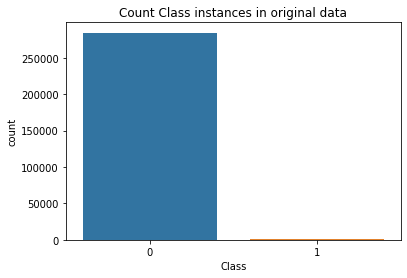

In [236]:
sns.countplot(x='Class', data=dat)
plt.title('Count Class instances in original data')
plt.show()

#### Problem #2: Class overlapping

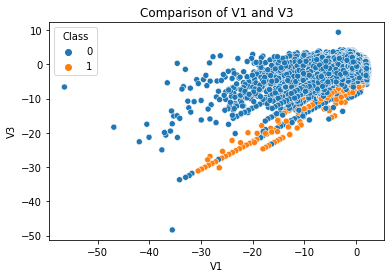

In [237]:
# compare 3 different plots here
sns.scatterplot(data=dat, x='V1', y='V3', hue='Class')
plt.title("Comparison of V1 and V3")
plt.show()

In [238]:
#separate data and labels
X = dat.loc[:,dat.columns!='Class']
y = dat['Class']

### Balancing the Training Dataset

In [239]:
# TODO: combination of SMOTE and random undersampling for imbalanced classification before applying models
X_sampled, y_sampled = SMOTE(sampling_strategy=0.1).fit_resample(X, y)
X_sampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


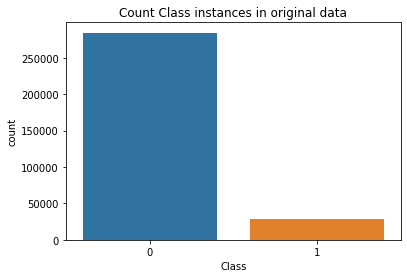

In [240]:
dat_sampled = X_sampled.copy()
dat_sampled["Class"] = y_sampled
sns.countplot(x='Class', data=dat_sampled)
plt.title('Count Class instances in original data')
plt.show()

In [241]:
X_sampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [242]:
X_sampled, y_sampled = RandomUnderSampler().fit_resample(X_sampled, y_sampled)
X_sampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,136473.0,0.115243,-0.793427,0.705285,-2.385837,-1.779586,-0.216607,-2.001486,-2.562863,-1.661140,...,0.115083,-1.123682,1.181921,-0.122522,0.528533,0.578954,-0.005773,0.124040,0.270976,38.10
1,81703.0,-0.381504,0.756250,1.257413,-0.046716,-0.004795,0.133250,0.877263,-0.131071,-0.108498,...,0.043793,-0.259844,-0.582296,-0.129711,-0.401451,0.032711,0.282693,-0.092151,-0.006205,79.99
2,84492.0,1.306872,-0.253435,0.596191,-0.935623,-0.661857,-0.314640,-0.479496,-0.073378,1.633800,...,0.004631,-0.048722,0.193656,-0.159398,-0.399905,0.666523,-0.639388,0.103232,0.030143,1.00
3,170894.0,0.013261,0.797229,0.174222,-0.785140,0.656237,-0.525104,0.894903,-0.016296,-0.289785,...,-0.017705,-0.223286,-0.492501,0.025974,-0.401460,-0.488649,0.146147,0.245905,0.083537,4.47
4,61926.0,1.378403,-0.555312,0.306548,-0.749069,-0.951514,-0.505148,-0.635154,-0.053735,-0.989529,...,-0.465470,-0.223238,-0.158315,-0.064155,0.048559,0.318713,1.164053,-0.057961,-0.007505,4.95


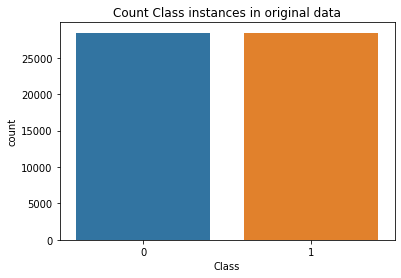

In [243]:
dat_sampled = X_sampled.copy()
dat_sampled["Class"] = y_sampled
sns.countplot(x='Class', data=dat_sampled)
plt.title('Count Class instances in original data')
plt.show()

In [244]:
# perform a train test split on imbalanced dataset
# train dataset split as 90% as cross validation will be performed afterwards
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, random_state=0, train_size = .75)

In [245]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
2952,118076.000000,-0.593266,1.670674,-0.765469,2.378510,2.323936,1.212950,1.163145,0.594799,-2.490843,...,-0.340318,0.359195,0.857543,0.011744,-0.573937,-0.631798,-0.017790,0.075024,0.135727,23.720000
34763,102480.718733,-1.958936,4.066224,-4.952432,5.801286,-0.674553,-1.548560,-3.886109,0.707441,-3.314388,...,0.968241,1.133368,0.698295,-0.539253,-0.441537,0.368179,0.195096,0.877671,0.236592,8.305354
52788,26911.989292,-22.168786,13.047174,-24.327211,6.215553,-16.650272,-4.475586,-16.641486,14.711353,-3.886242,...,1.615935,1.763798,-1.602712,-0.970868,0.136413,1.528997,-0.222441,1.517930,0.450436,99.990000
40993,85754.226243,-2.924022,3.054527,-5.575378,3.812480,-2.307686,-1.370344,-4.848771,2.181231,-2.925433,...,0.664792,0.892656,-0.049072,-0.364995,-0.761584,0.126878,-0.135538,1.181098,0.204265,92.390464
54222,64487.692407,1.079810,0.901265,-0.295735,2.751576,0.336521,-0.340997,-0.016367,0.224450,-0.838275,...,-0.227107,-0.018767,-0.126635,-0.043491,-0.049641,0.371545,0.075676,0.021487,0.061412,0.000000


In [246]:
# Count classes in split datasets
count_train_0 = y_train.value_counts()[0]
count_train_1 = y_train.value_counts()[1]
print(f"Train instances counts (Class 0, Class 1) = {(count_train_0, count_train_1)}")

count_test_0 = y_test.value_counts()[0]
count_test_1 = y_test.value_counts()[1]
print(f"Test instances counts (Class 0, Class 1) = {(count_test_0, count_test_1)}")

Train instances counts (Class 0, Class 1) = (21373, 21281)
Test instances counts (Class 0, Class 1) = (7063, 7155)


### Classifier Comparison

We will use a RandomForestClassifier as Baseline model

In [247]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [248]:
# instantiate the classifier 
NUM_ESTIMATORS = 100
clf = RandomForestClassifier(random_state=0,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [249]:
# fit the model to the training data
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=0, verbose=False)

In [250]:
# get predictions for test data
preds = clf.predict(X_test)

In [251]:
precision = precision_score(y_test,preds)
recall = recall_score(y_test,preds)
f1 = f1_score(y_test,preds)

In [252]:
print(f"The model's precision score is {round(precision,4)}") 
print(f"The model's recall score is {round(recall,4)}")
print(f"The model's F1 score is {round(f1,4)}")

The model's precision score is 0.9992
The model's recall score is 0.9978
The model's F1 score is 0.9985


In [254]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [2, 5, 10]
    }
    
clf = GridSearchCV(RandomForestClassifier(), params)
clf.fit(X_train, y_train)
pred_optim = clf.predict(X_test)
print(classification_report(y_test, pred_optim))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7063
           1       1.00      0.98      0.99      7155

    accuracy                           0.99     14218
   macro avg       0.99      0.99      0.99     14218
weighted avg       0.99      0.99      0.99     14218



## Confusion Matrix
As it can be observed in the confusion matrix, the classes are highly imbalanced. Therefore, the typical metrics for classification (such as Accuracy) are not meaningful in this scenario. For example, if 99 transactions are no frauds and 1 transaction is a fraud, a model which always predicts "no fraud" will reach 99% Accuracy, although it is not a good model for predictions. Both measures, Precision and Recall, focus on the minority class of positive frauds, which is what we want! But we need a combination of both!

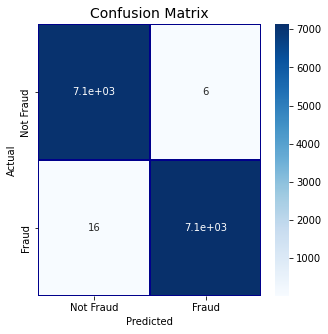

In [255]:
cm = pd.crosstab(y_test.values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## AUPRC - Area Under the Precision Recall Curve is your evaluation
A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. A model with perfect skill is depicted as a point at a coordinate of (1,1).  
A skillful model is represented by a curve that bows towards a coordinate of (1,1). A no-skill classifier will be a horizontal line on the plot with a precision that is proportional to the number of positive examples in the dataset. For a balanced dataset this will be 0.5.  
The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models.

In [256]:
precision, recall, _ = precision_recall_curve(y_test, preds)

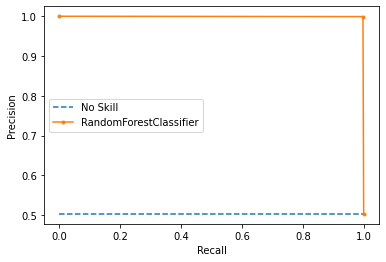

In [257]:
# calculate the no skill line as the proportion of the positive class
no_skill = y_test.mean()
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='RandomForestClassifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [258]:
auprc_score = auc(recall,precision)
auprc_score

0.9990246937726825

# Submission of fraudulent transactions 

In [259]:
# combine the predicitons on the train and test
submission = pd.DataFrame(clf.predict(X), \
                          #index=np.concatenate(X.index), \
                          columns=['AdvancedDetection'])

In [260]:
# Label the KNOWN fraudulent transactions
submission.loc[y[y==1].index,'AdvancedDetection'] = 1

In [261]:
# How many frauds are there now?
submission['AdvancedDetection'].sum()

997

In [262]:
submission['AdvancedDetection'].value_counts()

0    283810
1       997
Name: AdvancedDetection, dtype: int64

### Remember, EBA estimates that there are close to 11% more frauds 

In [263]:
# What is your percentage?
print('Advanced Detection Method labels {}% more frauds'.format(\
    np.round((submission['AdvancedDetection'].sum()-y.sum())/y.sum()*100),2))

Advanced Detection Method labels 126.0% more frauds


In [264]:
# EBA requests the whole 284,807 Class labels with hopefully
# some more insights on some other fraudulent transations
# that were not labled by the EBA

submission.to_csv('submission_GroupName.csv')